# LSTM modelling for time-series prediction


In [72]:
## Install dependencies
!pip install pandas numpy matplotlib tensorflow tensorflow-gpu

In [73]:
## Importing dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [74]:
## matplotlib parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [75]:
## file loading
directory= os.getcwd()
file= os.listdir(os.path.join(directory, 'src', 'datasets'))
csv_path= os.path.join(directory, 'src', 'datasets', file[0])
df = pd.read_csv(csv_path)

In [76]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [77]:
## 훈련을 위한 파라미터 설정
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
## 학습 시 파라미터
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [78]:
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [79]:
## if your PC is equipped with GPU device,tensorflow gpu activation
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus= tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Univariate LSTM modelling setting

### 단변량(Univariate LSTM) 데이터란?
입력값의 차원이 1인 것을 단변량이라고 합니다.
더 간단하게 생각하면, 변수 1개인 것을 단변량 데이터라고 하지요.
현재 구현하고 있는 LSTM 모델링은 '시계열 데이터'를 기반으로 하기 때문에,
입력값인 x feature는 '시간'이 됩니다.

In [80]:
## time-series prediction of univariate value
uni_data = df['T (degC)']  # y value = temperature
uni_data.index = df['Date Time']  # x value= time-series
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [81]:
## data arrangement
uni_data= uni_data.values

In [82]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

## 표준화(Standardization)
통계학에서는 z score가 있습니다.
데이터를 표준정규분포로 정렬하기 위해 계산하는 과정인데요.
표준화는 z score와 동일한 개념으로 이해할 수 있습니다.
표준화 계산은 (데이터 - 평균 / 표준편차)입니다.
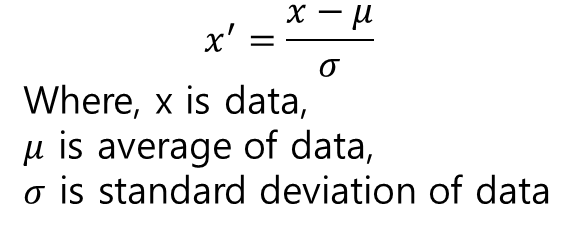
여기서 표준화 계산을 위한 평균, 표준편차 계산은 학습을 위한 데이터셋(train)의 평균, 표준편차 값이어야 합니다.

In [83]:
## data standardization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [84]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

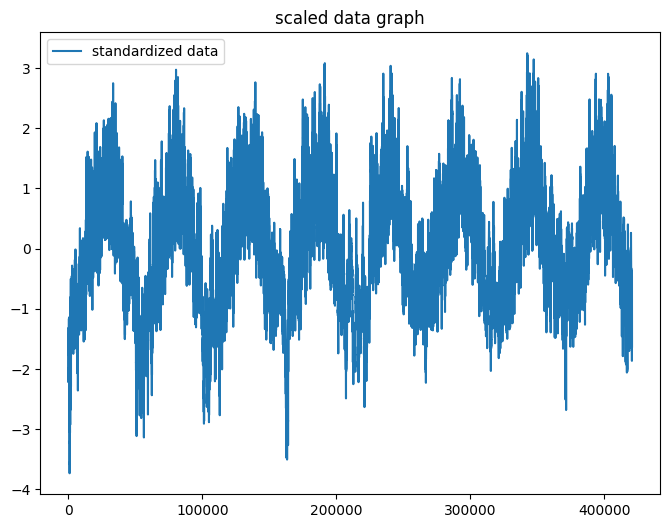

In [85]:
plt.plot(np.arange(len(uni_data)), uni_data, label='standardized data')
plt.title('scaled data graph')
plt.legend()
plt.show()

## 입력 데이터셋 구축하기(Dataset setting)
딥러닝 모델링의 70~80% 이상은 알맞은 데이터셋을 구축하는 것이라고 해도 과언이 아닙니다.
데이터의 이상치, 결측치를 보간(Interpolation)하고,
학습에 적합한 데이터 형태로 구축하는 것이 절대 간단하지 않기 때문이지요.
단변량 모델링 학습을 위한 데이터셋 구축을 해보도록 하겠습니다.

In [86]:
## data_window : data window의 크기 입니다 (하나의 데이터 윈도우에 몇 개의 데이터가 들어가는지)
## target : 예측해야하는 레이블 입니다.
def univariate_data(dataset, start_index, end_index, data_window, target):
  data, labels = [], []

  start_index = start_index + data_window
  if end_index is None:
    end_index = len(dataset) - target

  for i in range(start_index, end_index):
    indices = range(i-data_window, i)
    # Reshape data from (data_window,) to (data_window, 1)
    data.append(np.reshape(dataset[indices], (data_window, 1)))
    labels.append(dataset[i+target])
  return np.array(data), np.array(labels)

In [87]:
data_window = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           data_window,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       data_window,
                                       univariate_future_target)

In [88]:
print(x_train_uni.shape) # Input dimension= (20, 1) ## 299980 is batch size
print(y_train_uni.shape) # Input dimension= (1)

(299980, 20, 1)
(299980,)


## 학습 전 베이스라인 코드 결과 플롯해보기

In [89]:
def baseline(history):
  return np.mean(history)

In [90]:
def create_time_steps(length):
    return list(range(-length, 0))

In [91]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\vaiv\\Documents\\blog\\lstm_predict\\.lstm_predict\\lib\\site-packages\\matplotlib\\pyplot.py'>

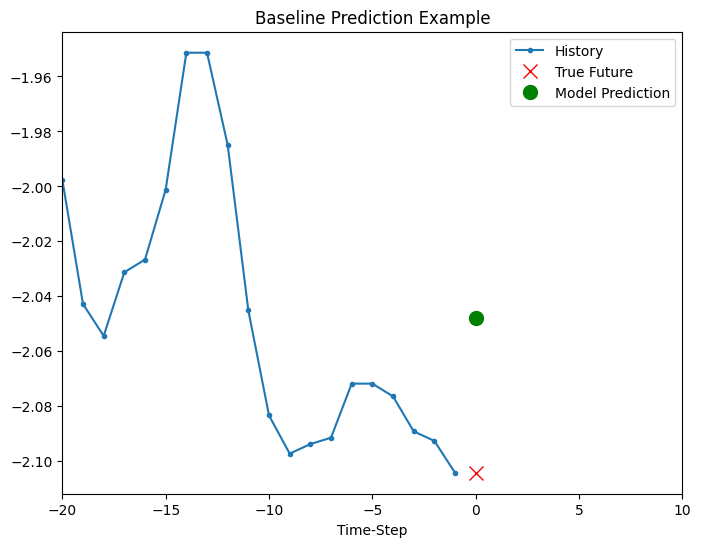

In [92]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

베이스라인으로 예측한 것을 보니 차이가 많이 나네요.
예측값이 데이터셋의 평균값이기 때문입니다.

때로는 데이터셋의 평균값이나, 바로 직전 값을 예측하는 것 보다
나은 성능의 모델링을 하는 것이 쉽지 않기도 합니다.

## 어쨌든! 학습을 위해 데이터셋 매서드를 통해 텐서 형태로 만들어줍니다.

In [93]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## 고대하던 모델링!

In [94]:
## model build
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

## model compile
simple_lstm_model.compile(optimizer='adam', loss='mae', metrics='mse')

## model fitting
history= simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 14ms/step - loss: 0.2730 - mse: 0.2083 - val_loss: 0.0569 - val_mse: 0.0059
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0580 - mse: 0.0114 - val_loss: 0.0267 - val_mse: 0.0016
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0353 - mse: 0.0031 - val_loss: 0.0229 - val_mse: 0.0012
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0328 - mse: 0.0033 - val_loss: 0.0204 - val_mse: 9.4382e-04
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0236 - mse: 0.0014 - val_loss: 0.0193 - val_mse: 8.5979e-04
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0258 - mse: 0.0018 - val_loss: 0.0188 - val_mse: 7.9727e-04
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0239 - mse: 0.0015 - val_loss: 0.0175 - val_mse: 7.1296e-04
Epoch 8/10
200/200 [==============================] -

In [95]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

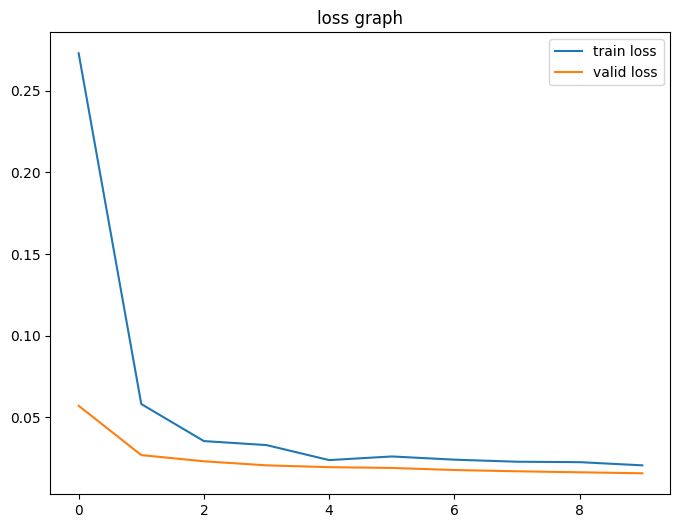

In [96]:
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'], label='train loss')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'], label='valid loss')
plt.legend()
plt.title('loss graph')
plt.show()

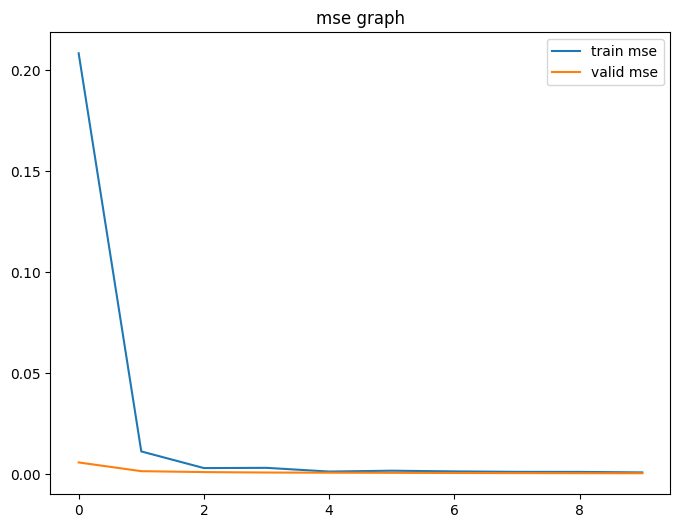

In [97]:
plt.plot(np.arange(len(history.history['mse'])),history.history['mse'], label='train mse')
plt.plot(np.arange(len(history.history['val_mse'])),history.history['val_mse'], label='valid mse')
plt.legend()
plt.title('mse graph')
plt.show()

## Inference
드디어 예측 모델링이 준비되었습니다.
단변량 모델링의 예측 성능이 어떠한 지 살펴보겠습니다!

8/8 [==============================] - 0s 3ms/step


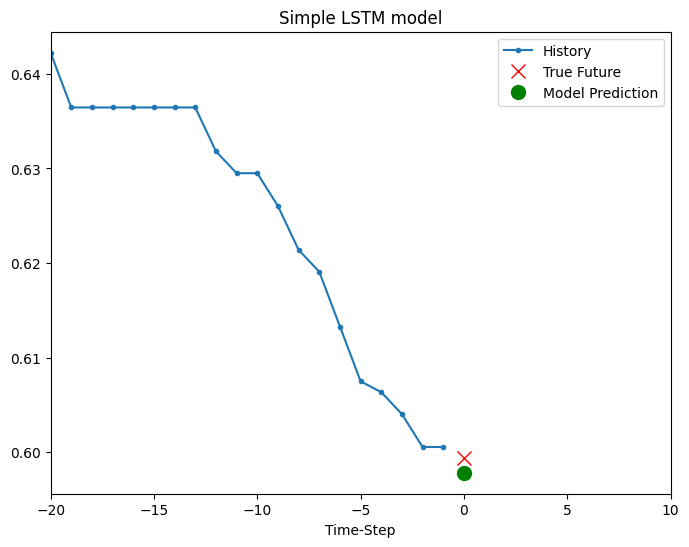

8/8 [==============================] - 0s 5ms/step


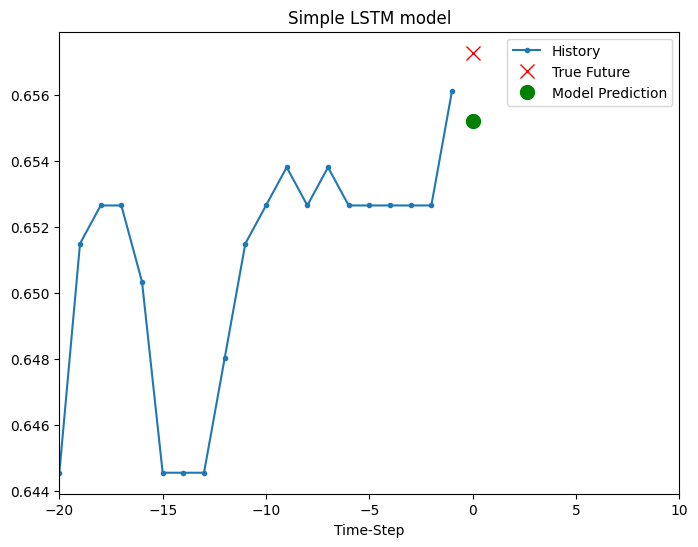

8/8 [==============================] - 0s 3ms/step


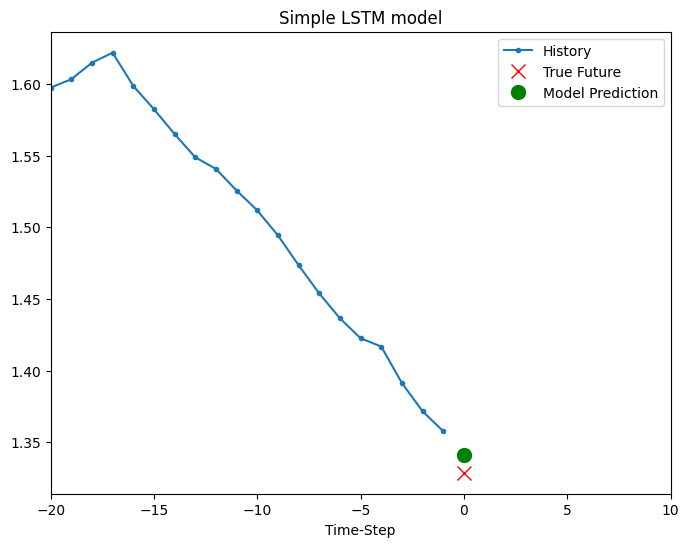

In [98]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()